In [ ]:
import sys
sys.path.append('..')
import os
import numpy as np
import torch
import torch.nn.functional as F
from base import BaseModel, sample_random, sample_uniform, sample_boundary2D_separate
from base import Random_Basis_Function,Random_Basis_Function_L
from vortex.visualize import draw_vector_field2D, draw_sc_field2D, draw_curl, draw_magnitude, save_numpy_img, save_figure, draw_vector_field2D_ut
from base import gradient, divergence, laplace, jacobian, hessian, hessian_use
# from torchsparsegradutils import sparse_triangular_solve, sparse_generic_solve
# from torchsparsegradutils.utils import linear_cg, minres, rand_sparse, rand_sparse_tri
from vortex.sparse_solver import sparse_solve
from scipy import sparse
from vortex.model import Vortex_L

from matplotlib import pyplot as plt
import math

In [13]:
import os
import argparse
from vortex import Vortex_L


# create experiment config containing all hyperparameters
cfg = argparse.ArgumentParser(add_help=False)
cfg.rho = 1
cfg.internal_v = 8
cfg.variable_list = [2,3]
cfg.time_num = 2
cfg.colloation_pts_num  = 81
cfg.boundary_num = 12
cfg.output_path = './results' 
cfg.gravity = 0
cfg.num_per_point_feature = 150
cfg.time_length = 0.2
cfg.num_spatial_basis = 16
cfg.variable_num = 3
cfg.dim = 2
cfg.device = 'cuda'
#cfg.band_width = 0.5
cfg.log_dir = './log'
cfg.n_timesteps = 100000
cfg.neighbor_K  = 4
cfg.vis_resolution = 100
cfg.seed = 43543
cfg.dt = 0.01
model = Vortex_L(cfg)
print(torch.sum(model.spatial_A[0,:,0,:,:],dim=-2))

tensor([[ 4.4902, -1.5306],
        [-2.4706,  1.7476],
        [ 3.7451,  0.0176],
        [-1.3412, -1.4993],
        [-0.3901, -0.7798],
        [ 2.3400,  3.0237],
        [-0.6967, -0.5480],
        [ 1.8920, -0.0279],
        [-1.0025,  2.0807],
        [-0.5915, -0.9924],
        [-2.1576, -0.0823],
        [ 0.3248, -0.2956],
        [-0.4879, -1.2674],
        [-1.1875,  0.2009],
        [ 0.1209, -1.4602],
        [ 1.8218, -1.4243]], device='cuda:0')


tensor([[ 0.3333,  1.0000],
        [ 0.3333, -1.0000],
        [-1.6667, -1.0000],
        [-1.6667,  1.0000]], device='cuda:0', grad_fn=<SelectBackward0>) tensor([1, 2, 6, 5], device='cuda:0')


/tmp/ipykernel_621267/1879347099.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(model.total_samples[13,0].detach().cpu().numpy(), model.total_samples[13,1].detach().cpu().numpy(),c=np.array([1,0,0]))


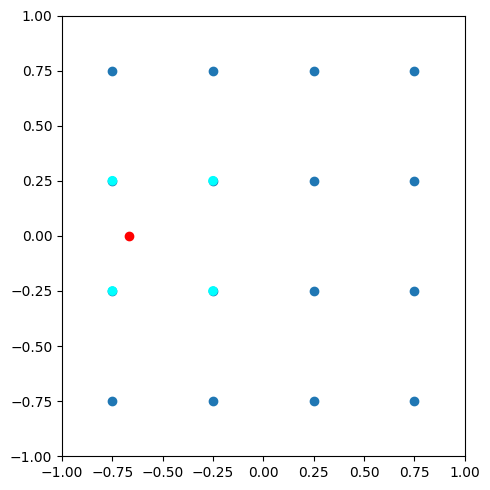

In [14]:
ts,qs,ds = model.total_samples.shape

model.total_samples = model.total_samples.reshape(ts*qs,ds)
x_,idx = model.neighbor_search_spatial(model.total_samples.reshape(ts,qs,ds))

fig, ax = plt.subplots(figsize=(5, 5))
#ax.quiver(x, y, u, v, scale=u.shape[0], scale_units='width')
# print(x_.shape)
ct = np.repeat(np.array([[0,1,1]]),x_.shape[2],axis=0)
# print(ct.shape)
#A_ = x_.reshape(-1,2)
#ct = np.repeat(np.array([[0,0,1]]),A_.shape[0],axis=0)
ax.scatter(model.total_samples[13,0].detach().cpu().numpy(), model.total_samples[13,1].detach().cpu().numpy(),c=np.array([1,0,0]))
ax.scatter(model.basis_point[0,:,0].detach().cpu().numpy(), model.basis_point[0,:,1].detach().cpu().numpy())
ax.scatter(model.basis_point[0,idx[0,13],0].detach().cpu().numpy(), model.basis_point[0,idx[0,13],1].detach().cpu().numpy(),c=ct)
print(x_[0,13],idx[0,13])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
fig.tight_layout()


In [15]:
total_ = model.num_time_feature*model.num_spatial_basis
h = idx.shape[2]
bz = idx.shape[1]
A_process = model.spatial_A.reshape(model.num_time_feature,model.num_spatial_basis,-1)
#print(A_process[0,:,12])
A_process = A_process.unsqueeze(1).expand(-1,bz,-1,-1)
idx_ = idx.unsqueeze(-1).expand(-1,-1,-1,A_process.shape[-1]) 
#print(A_process.shape,idx_.shape)
A_process = torch.gather(A_process,2,idx_)
#print(A_process[0,13,:,12])
A_process = A_process.reshape(model.num_time_feature,-1,h,model.variable_num,model.num_per_point_feature,model.dim)
bias_process = model.bias.reshape(model.num_time_feature,model.num_spatial_basis,-1)
bias_process = bias_process.unsqueeze(1).expand(-1,bz,-1,-1)
idx_ = idx.unsqueeze(-1).expand(-1,-1,-1,bias_process.shape[-1]) 
bias_process = torch.gather(bias_process,2,idx_).reshape(model.num_time_feature,-1,h,model.variable_num,model.num_per_point_feature)
#print(x_.shape)
sptail_val = torch.einsum('tqhejd,tqhd->tqhej',A_process,x_)
#print(A_process[0,13,:,:,12,:],x_[0,13,:,:],sptail_val[0,13,:,:,12])
ot = model.non_linear(sptail_val+bias_process)

#print(model.total_samples.shape)
time_total = model.total_samples.reshape(model.num_time_feature,-1,model.dim)
x_weight = model.PoU(x_)
x_weight = x_weight[...,0] * x_weight[...,1]
#print(x_weight[0,13],x_[0,13])
ot = ot * x_weight[...,None,None]
print(ot[0,-4:])

t_,q_,h_,e_,j_ = ot.shape
ot_lap = ot.permute(0,1,2,4,3).reshape(t_,q_,h_,j_,e_)[...,2:]
ot_lap = ot_lap.reshape(t_*q_,-1)
ot = ot.reshape(ot.shape[0]*ot.shape[1],-1)

print(ot.shape)
L1,_ = jacobian(ot, model.total_samples,create_graph=False)
L1 = L1.reshape(t_,q_,h_,e_,j_,-1)
#print(L1[0,13,:,:,12])

lap_g,_ = jacobian(ot_lap,model.total_samples)
lap_g = lap_g.reshape(t_,q_,h_,j_,model.dim)
#print(lap_g[0,13,:,12])

lap,_ = jacobian(lap_g.reshape(t_*q_,-1),model.total_samples,create_graph=False)
lap = lap.reshape(t_,q_,h_,j_,model.dim,model.dim)

lap = torch.einsum('abcdee->abcd',lap)
ot = ot.reshape(t_,q_,h_,e_,j_)

# print(lap[0,13,:,12])

tensor([[[[ 0.1020,  0.3196,  0.1851,  ...,  0.0805, -0.0151, -0.2976],
          [-0.0131, -0.2778,  0.3864,  ..., -0.1481,  0.3467,  0.0116],
          [ 0.1873, -0.3242,  0.3436,  ...,  0.3013,  0.1659,  0.0858]],

         [[-0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
          [-0.0000,  0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]],

         [[-0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0000, -0.0000],
          [ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000, -0.0000],
          [-0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.0000]]],


        [[[-0.1031, -0.3575,  0.3316,  ..., -0.2634, -0.1781,  0.1685],
          [-0.2022, -0.2037,  0.0811,  ...,  0.3581, -

In [16]:
print(idx.shape,idx[0,13])
h_use = idx.shape[2]
bz_use = idx.shape[1]
idx_box = model.idx_box.reshape(model.num_spatial_basis,-1)
idx_box = idx_box.unsqueeze(0).expand(bz_use,-1,-1)
idx_ = idx[0].unsqueeze(-1).expand(-1,-1,idx_box.shape[-1]) 
idx_box = torch.gather(idx_box,1,idx_).reshape(-1,h_use,model.variable_num,model.num_per_point_feature)
global_idx_box = model.global_idx_box.unsqueeze(0).expand(bz_use,-1,-1)
print(global_idx_box.shape)

torch.Size([2, 93, 4]) tensor([1, 2, 6, 5], device='cuda:0')
torch.Size([93, 3, 150])


In [17]:
def linear_solver(LHS_tp,RHS_tp,idx_tp,time):
    LHS = []
    RHS = []
    idx = []
    num = 0
    for i,LHS_ in enumerate(LHS_tp):
        max_x = torch.abs(LHS_)
        max_x = torch.max(max_x,1).values + 1e-10
        LHS.append(LHS_)
        RHS.append(RHS_tp[i])

        idx_tp[i][:,1] = idx_tp[i][:,1] + num
        #print(idx_tp[i][:,0])
        idx.append(idx_tp[i])
        #print(LHS_.shape[0]*LHS_.shape[1],idx_tp[i].shape[0],RHS_tp[i].shape)
        num += LHS_.shape[0] 
    #LHS: q?h?ej
    q = sum([i.shape[0] for i in LHS])
    h = model.num_spatial_basis*model.variable_num*model.num_per_point_feature + model.variable_num * model.num_per_point_feature

    # maybe fix former
    LHS = torch.cat([i.reshape(-1) for i in LHS],dim=0)
    idx = torch.cat(idx,dim=0).long()
    idx = torch.stack([idx[:,1],idx[:,0]],dim=1)
    LHS = LHS.double().clone().detach().cpu().numpy()
    idx = idx.clone().detach().cpu().numpy()
    mask = (LHS==0)
    LHS = LHS[~mask]
    idx = idx[~mask]
    A = sparse.coo_matrix((LHS,(idx[:,0],idx[:,1])),shape=(q,h)).tocsr()
    b = torch.cat(RHS,dim=0).double().clone().detach().cpu().numpy()

    utz = A.shape[1]
    # idxu = (A.getnnz(0)>0)
    # A = A[:,A.getnnz(0)>0]
    out = sparse.linalg.lsqr(A,b)
    print(out[1:5])
    num1 = LHS_tp[0].shape[0]
    # num2 = LHS_tp[1].shape[0]
    # print((A[num1:num1+num2]@out[0]).shape,b[num1:num1+num2].shape)
    # print(A[num1:num1+num2]@out[0],b[num1:num1+num2])
    #print(A[:num1]@out[0],b[:num1])


    a,b,c,d = model.u_.shape
    u = out[0]
    ut = np.zeros(utz)
    ut = u
    ut = torch.from_numpy(ut).to(model.device)
    
    model.u_ = model.u_.reshape(a,-1)
    t_g,e_g,j_g = model.global_u_.shape
    model.global_u_ = model.global_u_.reshape(t_g,-1)
    with torch.no_grad():
        model.u_[time] = ut[:b*c*d]
        # model.global_u_[time] = ut[b*c*d:]
    model.u_ = model.u_.reshape(a,b,c,d)
    model.global_u_ = model.global_u_.reshape(t_g,e_g,j_g)

    out,p = model.inference_time(model.total_samples.reshape(model.num_time_feature,-1,model.dim)[time,:],time)
    velos, samples = out,model.total_samples.reshape(model.num_time_feature,-1,model.dim)[time,:]
    velos = velos.clone().detach().cpu().numpy()
    samples = samples.clone().detach().cpu().numpy()
    velos = velos.reshape(-1,model.variable_list[0])
    p = p.clone().detach().cpu().numpy().reshape(-1,1)
    samples = samples.reshape(-1,2)
    
    # fig = draw_vector_field2D(velos[:,:], samples[:,:])
    # #print(np.min(p),np.max(p))
    # fig2 = draw_sc_field2D(p[:,:], samples[:,:])


In [18]:
def semi_lagrangian_advection(model,samplest,prev_u,time):
    samples = samplest[time].clone().detach().requires_grad_(True)
    
    backtracked_position = samples - prev_u * model.cfg.dt
    #print(backtracked_position.shape,prev_u.shape)
    backtracked_position = torch.clamp(samples, min=-1.0-1e-3, max=1.0+1e-3)
    # we need a neighbor mechanism and derive the speed
    x_,idx = model.neighbor_search_single(samples.unsqueeze(0),time-1)
    h = idx.shape[1]
    bz = idx.shape[0]
    A_process = model.spatial_A[time-1].reshape(model.num_spatial_basis,-1)
    A_process = A_process.unsqueeze(0).expand(bz,-1,-1)
    idx_ = idx.unsqueeze(-1).expand(-1,-1,A_process.shape[-1]) 
    #print(A_process.shape,idx_.shape)
    A_process = torch.gather(A_process,1,idx_)
    A_process = A_process.reshape(-1,h,model.variable_num,model.num_per_point_feature,model.dim)
    bias_process = model.bias[time-1].reshape(model.num_spatial_basis,-1)
    bias_process = bias_process.unsqueeze(0).expand(bz,-1,-1)
    idx_ = idx.unsqueeze(-1).expand(-1,-1,bias_process.shape[-1]) 
    bias_process = torch.gather(bias_process,1,idx_).reshape(-1,h,model.variable_num,model.num_per_point_feature)
    u_process = model.u_[time-1].reshape(model.num_spatial_basis,-1)
    u_process = u_process.unsqueeze(0).expand(bz,-1,-1)
    idx_ = idx.unsqueeze(-1).expand(-1,-1,u_process.shape[-1])
    u_process = torch.gather(u_process,1,idx_).reshape(-1,h,model.variable_num,model.num_per_point_feature)
    sptail_val = torch.einsum('qhejd,qhd->qhej',A_process,x_)
    ot = model.non_linear(sptail_val+bias_process)
    x_weight = model.PoU(x_)
    x_weight = x_weight[...,0] * x_weight[...,1]
    ot = ot * x_weight[...,None,None]

    u_current = torch.einsum('qhej,qhej->qe',ot,u_process)
    
    global_feature = model.non_linear(torch.einsum('ejd,qd->qej',model.low_basis_A[time-1],samples) + model.low_bias_A[time-1,None,:,:])
    global_feature = torch.einsum('qej,ej->qe',global_feature,model.global_u_[time-1])
    u_current = u_current
    L1,_ = jacobian(u_current[:,:2], samples)
    #print(L1[800:900])
    L1 = torch.einsum('qdd->q',L1)
    return u_current[:,:2], L1, backtracked_position

In [19]:
def draw_sc_field2D(vel, coords):
    u = vel[..., 0]
    x, y = coords[..., 0], coords[..., 1]

    fig, ax = plt.subplots(figsize=(5, 5))
    #ax.quiver(x, y, u, v, scale=u.shape[0], scale_units='width')
    vt = u
    # ct = vt[:,None]*np.array([[0,0,1]])/np.max(vt)
    # print(ct.shape,vt)
    #print(np.max(vt),vt)
    ax.scatter(x, y, c = vt,vmin=0,vmax=8)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    fig.tight_layout()
    return fig

In [20]:
def draw_vector_field2D(vel, coords):
    u, v = vel[..., 0], vel[..., 1]
    x, y = coords[..., 0], coords[..., 1]

    fig, ax = plt.subplots(figsize=(5, 5))
    #ax.quiver(x, y, u, v, scale=u.shape[0], scale_units='width')
    vt = u
    # ct = vt[:,None]*np.array([[0,0,1]])/np.max(vt)
    # print(ct.shape,vt)
    #print(np.max(vt),vt)
    ax.scatter(x, y, c = vt)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    fig.tight_layout()
    return fig

: 

torch.Size([132, 4, 3, 150]) 132
(1, 67, 0.04571095301702148, 0.04571095301702148)
12
[[ 3.31929321e+01  0.00000000e+00]
 [ 3.23720169e+01  0.00000000e+00]
 [ 3.03152466e+01  0.00000000e+00]
 [ 4.38221741e+00  0.00000000e+00]
 [ 5.88820457e+00  0.00000000e+00]
 [ 7.15784788e+00  0.00000000e+00]
 [ 8.88276672e+00  0.00000000e+00]
 [ 7.71177483e+00  0.00000000e+00]
 [ 6.03943396e+00  0.00000000e+00]
 [ 8.15481377e+00  0.00000000e+00]
 [ 8.80127525e+00  0.00000000e+00]
 [ 9.22502518e+00  0.00000000e+00]
 [ 4.60052490e-03  0.00000000e+00]
 [-1.01470947e-02  0.00000000e+00]
 [ 5.19561768e-03  0.00000000e+00]
 [ 4.01735306e-03  0.00000000e+00]
 [-1.12795830e-03  0.00000000e+00]
 [ 8.69035721e-04  0.00000000e+00]
 [-1.34382248e-02  0.00000000e+00]
 [ 1.88217163e-02  0.00000000e+00]
 [-1.05857849e-02  0.00000000e+00]
 [-6.88552856e-04  0.00000000e+00]
 [ 4.91952896e-03  0.00000000e+00]
 [-3.61919403e-03  0.00000000e+00]
 [-4.51660156e-03  0.00000000e+00]
 [ 1.01623535e-02  0.00000000e+00]
 [-5

IndexError: index 2 is out of bounds for dimension 0 with size 2

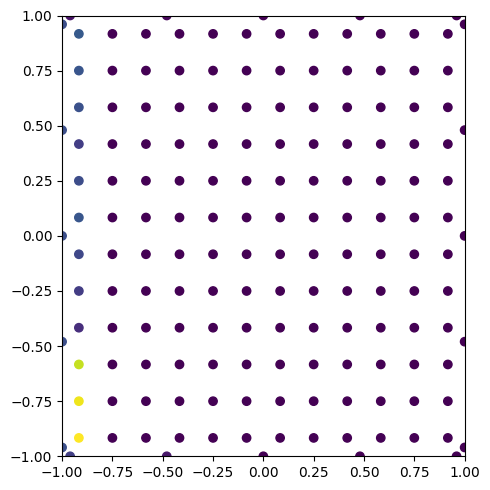

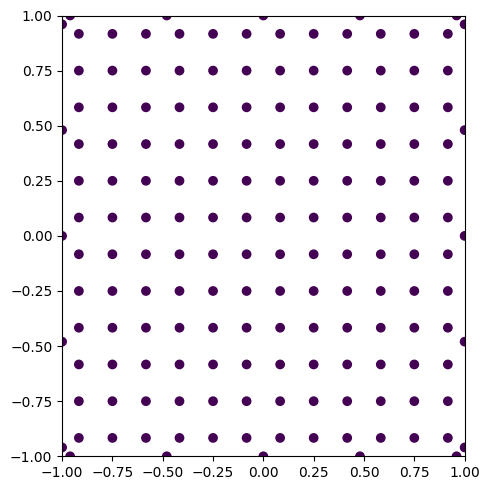

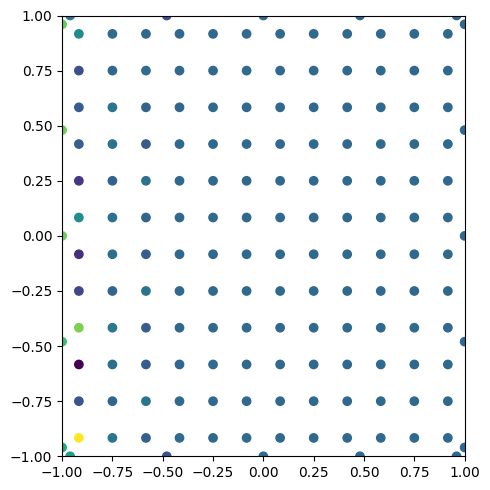

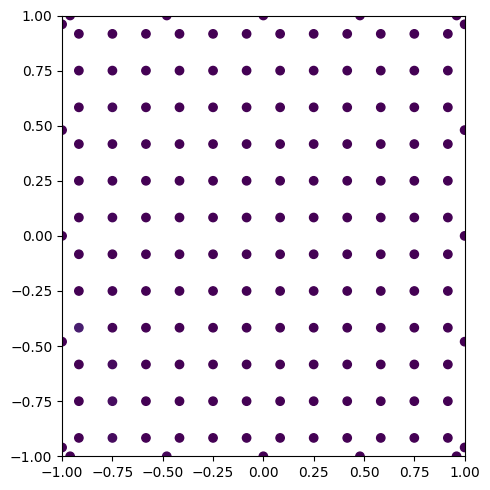

In [11]:
for time in range(10):
    if time>0:
        u_curr,L_u_curr,samples = semi_lagrangian_advection(model,model.total_samples.reshape(model.num_time_feature,-1,model.dim),uk,time)
        # we do not consider "g" temporally
        # ot:tqhej;L1 tqhejd
        velos, samples = u_curr,samples.reshape(-1,model.dim)
        L_u_curr = L_u_curr.reshape(-1,1)
        RHS_1 = L_u_curr[model.inner_pts].reshape(model.inner_pts.shape[0])
        RHS_2 = u_curr[model.inner_pts]
    else:
        resolution = int(math.pow(model.colloation_pts_num,1/model.dim))
        RHS_1 = torch.zeros(model.inner_pts.shape[0]).to(model.device)
        RHS_1[:resolution] = -cfg.internal_v/(2*resolution)
        RHS_1 = RHS_1.reshape(-1)
        RHS_2 = torch.zeros_like(ot[time,model.inner_pts,0,:model.variable_list[0],0])
    
    num = 0
    lap_use = lap[time]
    LHS_1 = lap_use[model.inner_pts].reshape(model.inner_pts.shape[0],-1)/cfg.rho
    LHS_1 = torch.cat([LHS_1],dim=1)
    idx1 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:].squeeze(2) 
    idx12 = global_idx_box[model.inner_pts,model.variable_list[0]:model.variable_list[1]]
    idx1 = idx1.reshape(model.inner_pts.shape[0],-1)      
    idx12 = idx12.reshape(model.inner_pts.shape[0],-1)
    idx1 = torch.cat([idx1],dim=1)
    dimk = torch.linspace(0,idx1.shape[0]-1,idx1.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx1.shape[1])
    idx1 = torch.stack([idx1,dimk],dim=2).reshape(-1,2)    


    part_1 = ot[time,model.inner_pts,:,:model.variable_list[0],:]

    part_2 = lap_g[time,model.inner_pts]/cfg.rho


    part_1 = part_1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)

    part_1 = torch.cat([part_1],dim=1)
    part_2 = part_2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)

    part_2 = torch.cat([part_2],dim=1)
    LHS_2 = torch.cat([part_1,part_2],dim=1)
    RHS_2 = RHS_2.reshape(model.inner_pts.shape[0]*model.variable_list[0])
    #idx1 = model.expand_idx(idx[model.inner_pts],0,model.variable_list[0]) #(qe)hj
    idx2_part1 = idx_box[model.inner_pts,...,:model.variable_list[0],:]
    idx2_part12 = global_idx_box[model.inner_pts,:model.variable_list[0]].reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)

    idx2_part2 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:]
    idx2_part2 = idx2_part2.unsqueeze(-1).expand(-1,-1,-1,-1,model.variable_list[0]).squeeze(2)
    idx2_part22 = global_idx_box[model.inner_pts,model.variable_list[0]:model.variable_list[1]].unsqueeze(-1).expand(-1,-1,-1,model.variable_list[0]).squeeze(1)
    idx2_part22 = idx2_part22.permute(0,2,1).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)

    idx2_part1 = idx2_part1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
    idx2_part1 = torch.cat([idx2_part1],dim=1)

    idx2_part2 = idx2_part2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
    idx2_part2 = torch.cat([idx2_part2],dim=1)

    idx2 = torch.cat([idx2_part1,idx2_part2],dim=1)
    #print(LHS_1.shape,idx1.shape)
    dimk = torch.linspace(0,idx2.shape[0]-1,idx2.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx2.shape[1])
    idx2 = torch.stack([idx2,dimk],dim=2).reshape(-1,2)


    num = 0
    # LHS3: q'hej (Some problem!!!)
    #print("norm",model.norm.shape)
    LHS_3 = torch.einsum('qhdj,qd->qhdj',ot[time,model.neu_bound,:,:model.variable_list[0]], model.norm)
    RHS_3 = torch.zeros_like(ot[time,model.neu_bound,0,0,0])
    LHS_3 = LHS_3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
    LHS_3 = torch.cat([LHS_3],dim=1)
    RHS_3 = RHS_3.reshape(model.neu_bound.shape[0])
    #idx3 = model.expand_idx_norm(idx[model.neu_bound],0,model.variable_list[0]) #(q)ehj
    idx3 = idx_box[model.neu_bound,:,:model.variable_list[0]]
    idx3 = idx3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
    idx32 = global_idx_box[model.neu_bound,:model.variable_list[0]]
    idx32 = idx32.reshape(model.neu_bound.shape[0],-1)
    idx3 = torch.cat([idx3],dim=1)
    dimk = torch.linspace(num,num+LHS_3.shape[0]-1,LHS_3.shape[0]).unsqueeze(-1).repeat(1,LHS_3.shape[1]).to(model.device)
    idx3 = torch.stack([idx3,dimk],dim=2).reshape(-1,2)



    # LHS4: q'hej
    num = 0
    LHS_4 = ot[time,model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
    RHS_4 = torch.zeros_like(ot[time,model.dir_bound,0,0,0])
    LHS_4 = LHS_4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
    RHS_4 = RHS_4.reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]))
    LHS_4 = torch.cat([LHS_4],dim=1)
    #idx4 = model.expand_idx(idx[model.dir_bound],model.variable_list[0],model.variable_list[1]) #(qe)hj
    idx4 = idx_box[model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
    idx4 = idx4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
    idx42 = global_idx_box[model.dir_bound,model.variable_list[0]:model.variable_list[1]]
    idx42 = idx42.reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
    idx4 = torch.cat([idx4],dim=1)
    dimk = torch.linspace(num,num+LHS_4.shape[0]-1,LHS_4.shape[0]).unsqueeze(-1).repeat(1,LHS_4.shape[1]).to(model.device)
    idx4 = torch.stack([idx4,dimk],dim=2).reshape(-1,2)


    # LHS5: q'hej
    num = 0
    LHS_5 = ot[time,model.u_left,:,:model.variable_list[0],:]
    RHS_5 = torch.zeros_like(ot[time,model.u_left,0,:model.variable_list[0],0])
    RHS_5[...,1] = 0
    RHS_5[...,0] = model.internal_v
    LHS_5 = LHS_5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)
    RHS_5 = RHS_5.reshape(model.u_left.shape[0]*model.variable_list[0])
    idx5 = idx_box[model.u_left,...,:model.variable_list[0],:]
    idx5 = idx5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)

    dimk = torch.linspace(num,num+LHS_5.shape[0]-1,LHS_5.shape[0]).unsqueeze(-1).repeat(1,LHS_5.shape[1]).to(model.device)
    idx5 = torch.stack([idx5,dimk],dim=2).reshape(-1,2)


    LHS_6 = ot[time,model.inner_pts][resolution:]
    RHS_6 = torch.zeros_like(ot[time,model.inner_pts,0,:,0])[resolution:]
    print(LHS_6.shape,model.inner_pts.shape[0]-resolution)
    LHS_6 = LHS_6.permute(0,2,1,3).reshape((model.inner_pts.shape[0]-resolution)*model.variable_list[1],-1)
    RHS_6 = RHS_6.reshape((model.inner_pts.shape[0]-resolution)*model.variable_list[1])
    #idx6 = model.expand_idx(idx[model.init_pts],0,model.variable_list[1]) #(qe)hj
    idx6 = idx_box[model.inner_pts][resolution:]
    idx6 = idx6.permute(0,2,1,3).reshape((model.inner_pts.shape[0]-resolution)*model.variable_list[1],-1)
    dimk = torch.linspace(num,num+LHS_6.shape[0]-1,LHS_6.shape[0]).unsqueeze(-1).repeat(1,LHS_6.shape[1]).to(model.device)
    idx6 = torch.stack([idx6,dimk],dim=2).reshape(-1,2)

    if time==0:
        LHS_tp = [LHS_1,LHS_5,LHS_6]
        RHS_tp = [RHS_1,RHS_5,RHS_6]
        idx_tp = [idx1,idx5,idx6]
    else:
        LHS_tp = [LHS_1,LHS_2,LHS_3,LHS_4,LHS_5,LHS_6]
        RHS_tp = [RHS_1,RHS_2,RHS_3,RHS_4,RHS_5,RHS_6]
        idx_tp = [idx1,idx2,idx3,idx4,idx5,idx6]
    linear_solver(LHS_tp,RHS_tp,idx_tp,time)
    samples = model.sample_input(50)

    uk,p = model.inference_time(model.total_samples.reshape(model.num_time_feature,-1,model.dim)[time,:],time)

    velos, samples = uk,model.total_samples.reshape(model.num_time_feature,-1,model.dim)[time,:]
    velos = velos.clone().detach().cpu().numpy()
    samples = samples.clone().detach().cpu().numpy()
    velos = velos.reshape(-1,model.variable_list[0])
    p = p.clone().detach().cpu().numpy().reshape(-1,1)
    samples = samples.reshape(-1,2)
    print(resolution)
    fig = draw_vector_field2D(velos[:,:], samples[:,:])
    #print(np.min(p),np.max(p))
    fig2 = draw_sc_field2D(p[:,:], samples[:,:])
    print(velos)


In [ ]:
def inference_time(self,x,t):
    # x_: Q * dim
    x_,idx = self.neighbor_search_single(x.unsqueeze(0),t)
    #print("idx",idx.shape)
    #print(x_[795:800])
    total_ = self.num_time_feature*self.num_spatial_basis
    h = idx.shape[1]
    bz = idx.shape[0]
    #print(x.shape)
    A_process = self.spatial_A[t].reshape(self.num_spatial_basis,-1)
    A_process = A_process.unsqueeze(0).expand(bz,-1,-1)
    idx_ = idx.unsqueeze(-1).expand(-1,-1,A_process.shape[-1]) 
    #print(A_process.shape,idx_.shape)
    A_process = torch.gather(A_process,1,idx_)
    A_process = A_process.reshape(-1,h,self.variable_num,self.num_per_point_feature,self.dim)
    bias_process = self.bias[t].reshape(self.num_spatial_basis,-1)
    bias_process = bias_process.unsqueeze(0).expand(bz,-1,-1)
    idx_ = idx.unsqueeze(-1).expand(-1,-1,bias_process.shape[-1]) 
    bias_process = torch.gather(bias_process,1,idx_).reshape(-1,h,self.variable_num,self.num_per_point_feature)
    #print(x_.shape)
    u_process = self.u_[t].reshape(self.num_spatial_basis,-1)
    #print("u_procsss",u_process)
    u_process = u_process.unsqueeze(0).expand(bz,-1,-1)
    idx_ = idx.unsqueeze(-1).expand(-1,-1,u_process.shape[-1])
    u_process = torch.gather(u_process,1,idx_).reshape(-1,h,self.variable_num,self.num_per_point_feature)
    sptail_val = torch.einsum('qhejd,qhd->qhej',A_process,x_)
    #print(torch.sum(A_process[795:800,:,0],dim=-2))
    #print(sptail_val[0])
    #time_val = torch.einsum('qhej,qh->qhej',t_process_,t_)
    ot = sptail_val
    
    # x_weight = self.PoU(x_)
    # x_weight = x_weight[...,0] * x_weight[...,1]
    # ot = ot * x_weight[...,None,None]
    
    global_feature = self.non_linear(torch.einsum('ejd,qd->qej',self.low_basis_A[t],x) + self.low_bias_A[t,None,:,:])
    global_feature = torch.einsum('qej,ej->qe',global_feature,self.global_u_[t])

    #print(ot,u_process)
    u_current = torch.einsum('qhej->qe',ot)
    u_current = global_feature
    #print(ot.shape)
    return u_current[:,:2], u_current[:,2]

In [ ]:
time = 0
samples = model.sample_input(50)
up,p = model.inference_time(samples,time)

L1,_ = jacobian(up[:,:2], samples)
#print(L1[900:940])
L1 = torch.einsum('qdd->q',L1)

mask = (torch.abs(L1)>0)
#print(L1[795:800])
L1 = L1[mask]
velos, samples = up,samples.reshape(-1,model.dim)

velos = velos[mask].clone().detach().cpu().numpy()
samples = samples[mask].clone().detach().cpu().numpy()
velos = velos.reshape(-1,model.variable_list[0])
p = p.clone().detach().cpu().numpy().reshape(-1,1)
samples = samples.reshape(-1,2)
fig = draw_vector_field2D(velos, samples)

# print(np.min(p),np.max(p))
fig2 = draw_sc_field2D(L1.clone().detach().cpu().numpy()[:,None], samples[:,:])
#print(model.band_width)

print(torch.sum(model.spatial_A[0,:,0,:,:],dim=-2))

fig3 = plt.figure()
_ = plt.hist(L1.detach().cpu().numpy(), bins=100)
plt.title("Histogram with 'auto' bins")
plt.show()


In [ ]:
time = 1
u_curr,L_u_curr,samples = semi_lagrangian_advection(model,model.total_samples.reshape(model.num_time_feature,-1,model.dim),uk,time)
# we do not consider "g" temporally
# ot:tqhej;L1 tqhejd

velos, samples = u_curr,samples.reshape(-1,model.dim)
L_u_curr = L_u_curr.reshape(-1,1)
velos = velos.clone().detach().cpu().numpy()
#print(velos.shape)
samples = samples.clone().detach().cpu().numpy()
velos = velos.reshape(-1,model.variable_list[0])
samples = samples.reshape(-1,2)
#print(L_u_curr.shape,samples.shape)
#print(np.max(velos[:,:].reshape(-1,2),axis=0))
print(velos[30:40])
fig = draw_vector_field2D(velos[:,:], samples[:,:])
fig2 = draw_sc_field2D(L_u_curr.clone().detach().cpu().numpy(), samples[:,:])

In [ ]:
print(global_feature_lap_g.shape)
print(global_idx_box.shape)

In [ ]:
time=1
lap_use = lap[time]
LHS_1 = -lap_use[model.inner_pts].reshape(model.inner_pts.shape[0],-1)/cfg.rho
LHS_12 = -global_feature_lap[time,model.inner_pts].reshape(model.inner_pts.shape[0],-1)/cfg.rho
RHS_1 = L_u_curr[model.inner_pts].reshape(model.inner_pts.shape[0])

LHS_1 = torch.cat([LHS_1,LHS_12],dim=1)
idx1 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:].squeeze(2) 
idx12 = global_idx_box[model.inner_pts,model.variable_list[0]:model.variable_list[1]]
idx1 = idx1.reshape(model.inner_pts.shape[0],-1)      
idx12 = idx12.reshape(model.inner_pts.shape[0],-1)
idx1 = torch.cat([idx1,idx12],dim=1)
dimk = torch.linspace(0,idx1.shape[0]-1,idx1.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx1.shape[1])
idx1 = torch.stack([idx1,dimk],dim=2).reshape(-1,2)    


part_1 = ot[time,model.inner_pts,:,:model.variable_list[0],:]
part_12 = global_feature[time,model.inner_pts,:model.variable_list[0],:]
part_2 = lap_g[time,model.inner_pts]/cfg.rho
part_22 = global_feature_lap_g[time,model.inner_pts]/cfg.rho
RHS_2 = u_curr[model.inner_pts]

part_1 = part_1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
part_12 = part_12.reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
part_1 = torch.cat([part_1,part_12],dim=1)
part_2 = part_2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
part_22 = part_22.permute(0,2,1).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
part_2 = torch.cat([part_2,part_22],dim=1)
LHS_2 = torch.cat([part_1,part_2],dim=1)
RHS_2 = RHS_2.reshape(model.inner_pts.shape[0]*model.variable_list[0])
#idx1 = model.expand_idx(idx[model.inner_pts],0,model.variable_list[0]) #(qe)hj
idx2_part1 = idx_box[model.inner_pts,...,:model.variable_list[0],:]
idx2_part12 = global_idx_box[model.inner_pts,:model.variable_list[0]].reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)

idx2_part2 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:]
idx2_part2 = idx2_part2.unsqueeze(-1).expand(-1,-1,-1,-1,model.variable_list[0]).squeeze(2)
idx2_part22 = global_idx_box[model.inner_pts,model.variable_list[0]:model.variable_list[1]].unsqueeze(-1).expand(-1,-1,-1,model.variable_list[0]).squeeze(1)
idx2_part22 = idx2_part22.permute(0,2,1).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)

idx2_part1 = idx2_part1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
idx2_part1 = torch.cat([idx2_part1,idx2_part12],dim=1)

idx2_part2 = idx2_part2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
idx2_part2 = torch.cat([idx2_part2,idx2_part22],dim=1)

idx2 = torch.cat([idx2_part1,idx2_part2],dim=1)
#print(LHS_1.shape,idx1.shape)
dimk = torch.linspace(0,idx2.shape[0]-1,idx2.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx2.shape[1])
idx2 = torch.stack([idx2,dimk],dim=2).reshape(-1,2)


num = 0
# LHS3: q'hej (Some problem!!!)
#print("norm",model.norm.shape)
LHS_3 = torch.einsum('qhdj,qd->qhdj',ot[time,model.neu_bound,:,:model.variable_list[0]], model.norm)
LHS_32 = torch.einsum('qdj,qd->qdj',global_feature[time,model.neu_bound,:model.variable_list[0]], model.norm).reshape(model.neu_bound.shape[0],-1)
RHS_3 = torch.zeros_like(ot[time,model.neu_bound,0,0,0])
LHS_3 = LHS_3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
LHS_3 = torch.cat([LHS_3,LHS_32],dim=1)
RHS_3 = RHS_3.reshape(model.neu_bound.shape[0])
#idx3 = model.expand_idx_norm(idx[model.neu_bound],0,model.variable_list[0]) #(q)ehj
idx3 = idx_box[model.neu_bound,:,:model.variable_list[0]]
idx3 = idx3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
idx32 = global_idx_box[model.neu_bound,:model.variable_list[0]]
idx32 = idx32.reshape(model.neu_bound.shape[0],-1)
idx3 = torch.cat([idx3,idx32],dim=1)
dimk = torch.linspace(num,num+LHS_3.shape[0]-1,LHS_3.shape[0]).unsqueeze(-1).repeat(1,LHS_3.shape[1]).to(model.device)
idx3 = torch.stack([idx3,dimk],dim=2).reshape(-1,2)



# LHS4: q'hej
num = 0
LHS_4 = ot[time,model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
LHS_42 = global_feature[time,model.dir_bound,model.variable_list[0]:model.variable_list[1]].reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)/cfg.rho
RHS_4 = torch.zeros_like(ot[time,model.dir_bound,0,0,0])
LHS_4 = LHS_4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
RHS_4 = RHS_4.reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]))
LHS_4 = torch.cat([LHS_4,LHS_42],dim=1)
#idx4 = model.expand_idx(idx[model.dir_bound],model.variable_list[0],model.variable_list[1]) #(qe)hj
idx4 = idx_box[model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
idx4 = idx4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
idx42 = global_idx_box[model.dir_bound,model.variable_list[0]:model.variable_list[1]]
idx42 = idx42.reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
idx4 = torch.cat([idx4,idx42],dim=1)
dimk = torch.linspace(num,num+LHS_4.shape[0]-1,LHS_4.shape[0]).unsqueeze(-1).repeat(1,LHS_4.shape[1]).to(model.device)
idx4 = torch.stack([idx4,dimk],dim=2).reshape(-1,2)


num = 0
LHS_5 = ot[time,model.u_left,:,:model.variable_list[0],:]
RHS_5 = torch.zeros_like(ot[time,model.u_left,0,:model.variable_list[0],0])
RHS_5[...,1] = 0
RHS_5[...,0] = model.internal_v
LHS_5 = LHS_5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)
LHS_52 = global_feature[time,model.u_left,:model.variable_list[0]].reshape(model.u_left.shape[0]*model.variable_list[0],-1)
LHS_5 = torch.cat([LHS_5,LHS_52],dim=1)

RHS_5 = RHS_5.reshape(model.u_left.shape[0]*model.variable_list[0])
idx5 = idx_box[model.u_left,...,:model.variable_list[0],:]
idx5_k = idx5.reshape(-1)
idx5 = idx5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)
idx52 = global_idx_box[model.u_left,:model.variable_list[0]].reshape(model.u_left.shape[0]*model.variable_list[0],-1)
idx5 = torch.cat([idx5,idx52],dim=1)

dimk = torch.linspace(num,num+LHS_5.shape[0]-1,LHS_5.shape[0]).unsqueeze(-1).repeat(1,LHS_5.shape[1]).to(model.device)
idx5 = torch.stack([idx5,dimk],dim=2).reshape(-1,2)


LHS_tp = [LHS_1,LHS_2,LHS_3,LHS_4,LHS_5]
RHS_tp = [RHS_1,RHS_2,RHS_3,RHS_4,RHS_5]
idx_tp = [idx1,idx2,idx3,idx4,idx5]
linear_solver(LHS_tp,RHS_tp,idx_tp,time)
samples = model.sample_input(50)

uk,p = model.inference_time(model.total_samples.reshape(model.num_time_feature,-1,model.dim)[time,:],time)

# L1,_ = jacobian(up[:,:2], samples)
# #print(L1[900:940])
# L1 = torch.einsum('qdd->q',L1)

# mask = (torch.abs(L1)>0)
# #print(L1[795:800])
# L1 = L1[mask]
# velos, samples = up,samples.reshape(-1,model.dim)

# velos = velos[mask].clone().detach().cpu().numpy()
# samples = samples[mask].clone().detach().cpu().numpy()
# velos = velos.reshape(-1,model.variable_list[0])
# p = p.clone().detach().cpu().numpy().reshape(-1,1)
# samples = samples.reshape(-1,2)
# fig = draw_vector_field2D(velos, samples)

# # print(np.min(p),np.max(p))
# fig2 = draw_sc_field2D(p, samples[:,:])
# #print(model.band_width)

# print(torch.sum(model.spatial_A[0,:,0,:,:],dim=-2))

# fig3 = plt.figure()
# _ = plt.hist(L1.detach().cpu().numpy(), bins=100)
# plt.title("Histogram with 'auto' bins")
# plt.show()



In [ ]:
time = 1
samples = model.sample_input(50)
up,p = model.inference_time(samples,time)

L1,_ = jacobian(up[:,:2], samples)
#print(L1[900:940])
L1 = torch.einsum('qdd->q',L1)

mask = (torch.abs(L1)>0)
#print(L1[795:800])
L1 = L1[mask]
velos, samples = up,samples.reshape(-1,model.dim)

velos = velos[mask].clone().detach().cpu().numpy()
samples = samples[mask].clone().detach().cpu().numpy()
velos = velos.reshape(-1,model.variable_list[0])
p = p.clone().detach().cpu().numpy().reshape(-1,1)
samples = samples.reshape(-1,2)
fig = draw_vector_field2D(velos, samples)

# print(np.min(p),np.max(p))
fig2 = draw_sc_field2D(L1.clone().detach().cpu().numpy()[:,None], samples[:,:])
#print(model.band_width)

print(torch.sum(model.spatial_A[0,:,0,:,:],dim=-2))

fig3 = plt.figure()
_ = plt.hist(L1.detach().cpu().numpy(), bins=100)
plt.title("Histogram with 'auto' bins")
plt.show()

In [ ]:
time = 1
u_curr,L_u_curr,samples = semi_lagrangian_advection(model,model.total_samples.reshape(model.num_time_feature,-1,model.dim),uk,time)
# we do not consider "g" temporally
# ot:tqhej;L1 tqhejd

velos, samples = u_curr,samples.reshape(-1,model.dim)
L_u_curr = L_u_curr.reshape(-1,1)
velos = velos.clone().detach().cpu().numpy()
#print(velos.shape)
samples = samples.clone().detach().cpu().numpy()
velos = velos.reshape(-1,model.variable_list[0])
samples = samples.reshape(-1,2)
#print(L_u_curr.shape,samples.shape)
#print(np.max(velos[:,:].reshape(-1,2),axis=0))
fig = draw_vector_field2D(velos[:,:], samples[:,:])
fig2 = draw_sc_field2D(L_u_curr.clone().detach().cpu().numpy(), samples[:,:])

# print(L_u_curr.detach().cpu().numpy())
# fig3 = plt.figure()
# _ = plt.hist(L_u_curr.detach().cpu().numpy(), bins=100)
# plt.title("Histogram with 'auto' bins")
# plt.show()

lap_use = lap[time]
##fix for solving poisson equation
# print(lap.shape)
# print(L_u_curr.shape)

LHS_1 = lap_use[model.inner_pts].reshape(model.inner_pts.shape[0],-1)/cfg.rho

RHS_1 = L_u_curr[model.inner_pts].reshape(model.inner_pts.shape[0])
# print(RHS_1)
# print(RHS_1.shape)
idx1 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:].squeeze(2) 
idx1 = idx1.reshape(model.inner_pts.shape[0],-1)      
dimk = torch.linspace(0,idx1.shape[0]-1,idx1.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx1.shape[1])
idx1 = torch.stack([idx1,dimk],dim=2).reshape(-1,2)    



part_1 = ot[time,model.inner_pts,:,:model.variable_list[0],:]
part_2 = -lap_g[time,model.inner_pts]/cfg.rho
RHS_2 = u_curr[model.inner_pts]
part_1 = part_1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
part_2 = part_2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
LHS_2 = torch.cat([part_1,part_2],dim=1)
RHS_2 = RHS_2.reshape(model.inner_pts.shape[0]*model.variable_list[0])
#idx1 = model.expand_idx(idx[model.inner_pts],0,model.variable_list[0]) #(qe)hj
idx2_part1 = idx_box[model.inner_pts,...,:model.variable_list[0],:]
idx2_part2 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:]
idx2_part2 = idx2_part2.unsqueeze(-1).expand(-1,-1,-1,-1,model.variable_list[0]).squeeze(2)
idx2_part1 = idx2_part1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
idx2_part2 = idx2_part2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
idx2 = torch.cat([idx2_part1,idx2_part2],dim=1)
#print(LHS_1.shape,idx1.shape)
dimk = torch.linspace(0,idx2.shape[0]-1,idx2.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx2.shape[1])
idx2 = torch.stack([idx2,dimk],dim=2).reshape(-1,2)
num = 0
# LHS3: q'hej (Some problem!!!)
#print("norm",model.norm.shape)
LHS_3 = torch.einsum('qhdj,qd->qhdj',ot[time,model.neu_bound,:,:model.variable_list[0]], model.norm)
RHS_3 = torch.zeros_like(ot[time,model.neu_bound,0,0,0])
LHS_3 = LHS_3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
RHS_3 = RHS_3.reshape(model.neu_bound.shape[0])
#idx3 = model.expand_idx_norm(idx[model.neu_bound],0,model.variable_list[0]) #(q)ehj
idx3 = idx_box[model.neu_bound,:,:model.variable_list[0]]
idx3 = idx3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
dimk = torch.linspace(num,num+LHS_3.shape[0]-1,LHS_3.shape[0]).unsqueeze(-1).repeat(1,LHS_3.shape[1]).to(model.device)
idx3 = torch.stack([idx3,dimk],dim=2).reshape(-1,2)

# LHS4: q'hej
num = 0
LHS_4 = ot[time,model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
RHS_4 = torch.zeros_like(ot[time,model.dir_bound,0,0,0])
LHS_4 = LHS_4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
RHS_4 = RHS_4.reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]))
#idx4 = model.expand_idx(idx[model.dir_bound],model.variable_list[0],model.variable_list[1]) #(qe)hj
idx4 = idx_box[model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
idx4 = idx4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
dimk = torch.linspace(num,num+LHS_4.shape[0]-1,LHS_4.shape[0]).unsqueeze(-1).repeat(1,LHS_4.shape[1]).to(model.device)
idx4 = torch.stack([idx4,dimk],dim=2).reshape(-1,2)
num = 0

# LHS5: q'hej
LHS_5 = ot[time,model.u_left,...,:model.variable_list[0],:]
RHS_5 = torch.zeros_like(ot[time,model.u_left,0,:model.variable_list[0],0])
RHS_5[...,1] = 0
RHS_5[...,0] = model.internal_v
LHS_5 = LHS_5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)
#print(RHS_5)
RHS_5 = RHS_5.reshape(model.u_left.shape[0]*model.variable_list[0])
# idx5 = model.expand_idx(idx[model.u_left],0,model.variable_list[0]) #(qe)hj
idx5 = idx_box[model.u_left,...,:model.variable_list[0],:]
idx5 = idx5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)

dimk = torch.linspace(num,num+LHS_5.shape[0]-1,LHS_5.shape[0]).unsqueeze(-1).repeat(1,LHS_5.shape[1]).to(model.device)
idx5 = torch.stack([idx5,dimk],dim=2).reshape(-1,2)

LHS_tp = [LHS_1,LHS_2,LHS_3,LHS_4,LHS_5]
RHS_tp = [RHS_1,RHS_2,RHS_3,RHS_4,RHS_5]
idx_tp = [idx1,idx2,idx3,idx4,idx5]
linear_solver(LHS_tp,RHS_tp,idx_tp,time)
uk,p = model.inference_time(model.total_samples.reshape(model.num_time_feature,-1,model.dim)[time,:],time)

# Here, we first consider 2D advection.

In [ ]:
# We need to follow the equation: (u_-u_curr)/cfg.dt  = \nabla p/rho
# and:                             \nabla \dot u = 0 && BC

for time in range(model.num_time_feature):
    if time>=1:
        u_curr,L_u_curr,samples = model.semi_lagrangian_advection(model.total_samples.reshape(model.num_time_feature,-1,model.dim),uk,time)
        # we do not consider "g" temporally
        # ot:tqhej;L1 tqhejd
        velos, samples = u_curr,samples.reshape(-1,model.dim)
        L_u_curr = L_u_curr.reshape(-1,1)
        velos = velos.detach().cpu().numpy()
        #print(velos.shape)
        samples = samples.detach().cpu().numpy()
        
        velos = velos.reshape(-1,model.variable_list[0])
        samples = samples.reshape(-1,2)
        #print(L_u_curr.shape,samples.shape)
        #print(np.max(velos[:,:].reshape(-1,2),axis=0))
        #fig = draw_vector_field2D(velos[:,:], samples[:,:])
        #fig2 = draw_sc_field2D(L_u_curr.detach().cpu().numpy(), samples[:,:])
        # print(L_u_curr.detach().cpu().numpy())
        # fig3 = plt.figure()
        # _ = plt.hist(L_u_curr.detach().cpu().numpy(), bins=100)
        # plt.title("Histogram with 'auto' bins")
        # plt.show()

        lap_use = lap[time]
        ##fix for solving poisson equation
        # print(lap.shape)
        # print(L_u_curr.shape)

        LHS_1 = lap_use[model.inner_pts].reshape(model.inner_pts.shape[0],-1)/cfg.rho
        
        RHS_1 = L_u_curr[model.inner_pts].reshape(model.inner_pts.shape[0])
        # print(RHS_1)
        # print(RHS_1.shape)
        idx1 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:].squeeze(2) 
        idx1 = idx1.reshape(model.inner_pts.shape[0],-1)      
        dimk = torch.linspace(0,idx1.shape[0]-1,idx1.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx1.shape[1])
        idx1 = torch.stack([idx1,dimk],dim=2).reshape(-1,2)    


        
        part_1 = ot[time,model.inner_pts,:,:model.variable_list[0],:]
        part_2 = -lap_g[time,model.inner_pts]/cfg.rho
        RHS_2 = u_curr[model.inner_pts]
        part_1 = part_1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        part_2 = part_2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        LHS_2 = torch.cat([part_1,part_2],dim=1)
        RHS_2 = RHS_2.reshape(model.inner_pts.shape[0]*model.variable_list[0])
        #idx1 = model.expand_idx(idx[model.inner_pts],0,model.variable_list[0]) #(qe)hj
        idx2_part1 = idx_box[model.inner_pts,...,:model.variable_list[0],:]
        idx2_part2 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:]
        idx2_part2 = idx2_part2.unsqueeze(-1).expand(-1,-1,-1,-1,model.variable_list[0]).squeeze(2)
        idx2_part1 = idx2_part1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        idx2_part2 = idx2_part2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        idx2 = torch.cat([idx2_part1,idx2_part2],dim=1)
        #print(LHS_1.shape,idx1.shape)
        dimk = torch.linspace(0,idx2.shape[0]-1,idx2.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx2.shape[1])
        idx2 = torch.stack([idx2,dimk],dim=2).reshape(-1,2)

        # part_1 = ot[time,model.inner_pts,:,:model.variable_list[0],:]/cfg.dt
        # ## Here is wrong with pressure (MAYBE!!!!!)
        # part_2 = -L1[time,model.inner_pts,:,model.variable_list[0]:model.variable_list[1],:,:]/cfg.rho
        # part_2 = part_2.squeeze(2)
        # print(part_2.shape)
        # RHS_1 = u_curr[model.inner_pts]/cfg.dt
        # part_1 = part_1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        # part_2 = part_2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        # print(part_1.shape,part_2.shape)
        # LHS_1 = torch.cat([part_1,part_2],dim=1)
        # RHS_1 = RHS_1.reshape(model.inner_pts.shape[0]*model.variable_list[0])
        # #idx1 = model.expand_idx(idx[model.inner_pts],0,model.variable_list[0]) #(qe)hj
        # idx1_part1 = idx_box[model.inner_pts,...,:model.variable_list[0],:]
        # idx1_part2 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:]
        # idx1_part2 = idx1_part2.unsqueeze(-1).expand(-1,-1,-1,-1,model.variable_list[0]).squeeze(2)
        # idx1_part1 = idx1_part1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        # idx1_part2 = idx1_part2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        # idx1 = torch.cat([idx1_part1,idx1_part2],dim=1)
        # #print(LHS_1.shape,idx1.shape)
        # dimk = torch.linspace(0,idx1.shape[0]-1,idx1.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx1.shape[1])
        # idx1 = torch.stack([idx1,dimk],dim=2).reshape(-1,2)        
        
        # num = 0
        # # LHS2: qhej
        # LHS_2 = torch.einsum('qhdjd->qhdj',L1[time,model.inner_pts,...,:model.variable_list[0],:,:])
        # RHS_2 = torch.zeros_like(ot[time,model.inner_pts,0,0,0])
        # LHS_2 = LHS_2.permute(0,2,1,3).reshape(model.inner_pts.shape[0],-1)
        # RHS_2 = RHS_2.reshape(model.inner_pts.shape[0])
        # #idx2 = model.expand_idx(idx[model.inner_pts],0,model.variable_list[0]) #(qe)hj
        # idx2 = idx_box[model.inner_pts,...,:model.variable_list[0],:]
        # idx2 = idx2.permute(0,2,1,3).reshape(model.inner_pts.shape[0],-1)

        # dimk = torch.linspace(num,num+LHS_2.shape[0]-1,LHS_2.shape[0]).to(model.device).unsqueeze(1).repeat(1,LHS_2.shape[1])
        # idx2 = torch.stack([idx2,dimk],dim=2).reshape(-1,2)




        num = 0
        # LHS3: q'hej (Some problem!!!)
        #print("norm",model.norm.shape)
        LHS_3 = torch.einsum('qhdj,qd->qhdj',ot[time,model.neu_bound,:,:model.variable_list[0]], model.norm)
        RHS_3 = torch.zeros_like(ot[time,model.neu_bound,0,0,0])
        LHS_3 = LHS_3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
        RHS_3 = RHS_3.reshape(model.neu_bound.shape[0])
        #idx3 = model.expand_idx_norm(idx[model.neu_bound],0,model.variable_list[0]) #(q)ehj
        idx3 = idx_box[model.neu_bound,:,:model.variable_list[0]]
        idx3 = idx3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
        dimk = torch.linspace(num,num+LHS_3.shape[0]-1,LHS_3.shape[0]).unsqueeze(-1).repeat(1,LHS_3.shape[1]).to(model.device)
        idx3 = torch.stack([idx3,dimk],dim=2).reshape(-1,2)


        # LHS4: q'hej
        num = 0
        LHS_4 = ot[time,model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
        RHS_4 = torch.zeros_like(ot[time,model.dir_bound,0,0,0])
        LHS_4 = LHS_4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
        RHS_4 = RHS_4.reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]))
        #idx4 = model.expand_idx(idx[model.dir_bound],model.variable_list[0],model.variable_list[1]) #(qe)hj
        idx4 = idx_box[model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
        idx4 = idx4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
        dimk = torch.linspace(num,num+LHS_4.shape[0]-1,LHS_4.shape[0]).unsqueeze(-1).repeat(1,LHS_4.shape[1]).to(model.device)
        idx4 = torch.stack([idx4,dimk],dim=2).reshape(-1,2)

        num = 0
        # LHS5: q'hej
        LHS_5 = ot[time,model.u_left,...,:model.variable_list[0],:]

        RHS_5 = torch.zeros_like(ot[time,model.u_left,0,:model.variable_list[0],0])
        RHS_5[...,1] = 0
        RHS_5[...,0] = model.internal_v
        LHS_5 = LHS_5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)
        #print(RHS_5)
        RHS_5 = RHS_5.reshape(model.u_left.shape[0]*model.variable_list[0])
        # idx5 = model.expand_idx(idx[model.u_left],0,model.variable_list[0]) #(qe)hj
        idx5 = idx_box[model.u_left,...,:model.variable_list[0],:]
        idx5 = idx5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)

        dimk = torch.linspace(num,num+LHS_5.shape[0]-1,LHS_5.shape[0]).unsqueeze(-1).repeat(1,LHS_5.shape[1]).to(model.device)
        idx5 = torch.stack([idx5,dimk],dim=2).reshape(-1,2)

        LHS_tp = [LHS_1,LHS_2,LHS_3,LHS_4,LHS_5]
        RHS_tp = [RHS_1,RHS_2,RHS_3,RHS_4,RHS_5]
        idx_tp = [idx1,idx2,idx3,idx4,idx5]
        linear_solver(LHS_tp,RHS_tp,idx_tp,time)
        uk,p = model.inference_time(model.total_samples.reshape(model.num_time_feature,-1,model.dim),time)
        
    else:
        # NEED Something in LHS5
        num = 0
        # LHS5: q'hej
        LHS_5 = ot[time,model.u_left,:,:model.variable_list[0],:]
        #print(model.u_left)
        RHS_5 = torch.zeros_like(ot[time,model.u_left,0,:model.variable_list[0],0])
        print(RHS_5.shape)
        RHS_5[...,1] = 0
        RHS_5[...,0] = model.internal_v
        LHS_5 = LHS_5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)
        #print(RHS_5)
        RHS_5 = RHS_5.reshape(model.u_left.shape[0]*model.variable_list[0])
        # idx5 = model.expand_idx(idx[model.u_left],0,model.variable_list[0]) #(qe)hj
        idx5 = idx_box[model.u_left,...,:model.variable_list[0],:]
        idx5 = idx5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)

        dimk = torch.linspace(num,num+LHS_5.shape[0]-1,LHS_5.shape[0]).unsqueeze(-1).repeat(1,LHS_5.shape[1]).to(model.device)
        idx5 = torch.stack([idx5,dimk],dim=2).reshape(-1,2)
           
        num = 0
        # LHS6: q'hej
        LHS_6 = ot[time,model.init_pts]
        RHS_6 = torch.zeros_like(ot[time,model.init_pts,0,:,0])
        LHS_6 = LHS_6.permute(0,2,1,3).reshape(model.init_pts.shape[0]*model.variable_list[1],-1)
        RHS_6 = RHS_6.reshape(model.init_pts.shape[0]*model.variable_list[1])
        # idx6 = model.expand_idx(idx[model.init_pts],0,model.variable_list[1]) #(qe)hj
        idx6 = idx_box[model.init_pts]
        idx6 = idx6.permute(0,2,1,3).reshape(model.init_pts.shape[0]*model.variable_list[1],-1)
        dimk = torch.linspace(num,num+LHS_6.shape[0]-1,LHS_6.shape[0]).unsqueeze(-1).repeat(1,LHS_6.shape[1]).to(model.device)
        idx6 = torch.stack([idx6,dimk],dim=2).reshape(-1,2)
        #print(model.init_pts,model.u_left)
        LHS_tp = [LHS_5,LHS_6]
        RHS_tp = [RHS_5,RHS_6]
        idx_tp = [idx5,idx6]
        linear_solver(LHS_tp,RHS_tp,idx_tp,time)
        uk,p = model.inference_time(model.total_samples.reshape(model.num_time_feature,-1,model.dim),time)
